In [24]:
import torch
import numpy as np
from model.models import UNet, UNetAttention, DoubleConv, UpSample, UNet_basic
from data.data import InvERTDataset
from pathlib import Path
from json5 import load as json_load
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
from matplotlib.colors import LogNorm, Normalize
from collections import OrderedDict

In [25]:
experiment_path = Path("/home/labo3A/results/u_net_23-04-2025_16h18")

In [26]:
class Transform:
    def __init__(self):
        pass

    def __call__(self, sample):
        sample['pseudosection'] = sample['pseudosection'].unsqueeze(0)

        pseudosection = sample['pseudosection']
        num_electrode_channel = torch.ones_like(pseudosection) * sample['num_electrode']
        subsection_length_channel = torch.ones_like(pseudosection) * sample['subsection_length']
        array_type_channel = sample['array_type']
        array_type_channel = array_type_channel.view(-1, 1, 1).expand(-1, pseudosection.shape[1], pseudosection.shape[2])
        sample['pseudosection'] = torch.cat((pseudosection, num_electrode_channel, subsection_length_channel, array_type_channel), dim=0)
        
        sample['norm_log_resistivity_model'] = sample['norm_log_resistivity_model'].unsqueeze(0)
        sample['JtJ_diag'] = sample['JtJ_diag'].unsqueeze(0)
        # sample['JtJ_diag'] = torch.ones_like(sample['JtJ_diag'])
        
        return sample

In [27]:
model_ckpt_path = experiment_path / "figures/model_output/checkpoints"
model_ckpt_list = sorted(model_ckpt_path.glob("*.pth"), key=lambda x: int(x.stem.split("_")[-1]))
print(f"Found {len(model_ckpt_list)} checkpoints, last one is {model_ckpt_list[-1].stem}")
model = UNet_basic()
model.load_state_dict(torch.load(model_ckpt_list[-1], map_location='cpu')['model_state_dict'])
model.eval()

Found 4 checkpoints, last one is model_epoch_4


UNet_basic(
  (conv_block1): Sequential(
    (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), groups=16)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
  )
  (upconv1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1

In [28]:
with open(experiment_path / 'config.json5', mode='r', encoding="utf8") as config_file:
    config_dict = json_load(config_file)

dataset = InvERTDataset(
    Path(config_dict['dataset']['dataset_name']),
    transform=Transform(),
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

DATASET: Found 18193 samples in /home/labo3A/samples_normalized.


In [35]:
sample = next(iter(dataloader))

num_electrodes = int(sample['num_electrode'] * 72 + 24)
array_type = sample['array_type']
pseudosection = sample['pseudosection']
norm_log_resistivity_model = sample['norm_log_resistivity_model']
JtJ_diag = sample['JtJ_diag']

print(f"num_electrodes: {num_electrodes}")
print(f"array_type: {array_type}")
print(f"pseudosection.shape: {pseudosection.shape}")
print(f"norm_log_resistivity_model.shape: {norm_log_resistivity_model.shape}")
print(f"JtJ_diag.shape: {JtJ_diag.shape}")

num_electrodes: 74
array_type: tensor([[0, 1]], dtype=torch.int32)
pseudosection.shape: torch.Size([1, 5, 36, 71])
norm_log_resistivity_model.shape: torch.Size([1, 1, 311, 415])
JtJ_diag.shape: torch.Size([1, 1, 311, 415])


In [36]:
output = model(pseudosection, norm_log_resistivity_model)

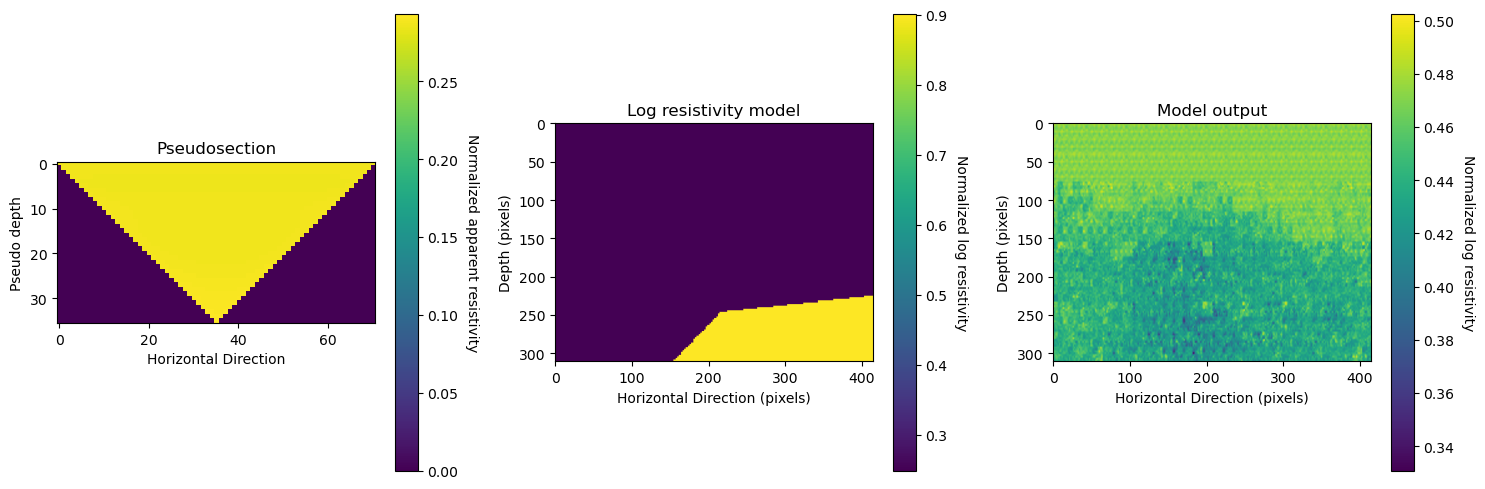

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(pseudosection[0, 0, :, :].detach().numpy(), cmap='viridis')
axes[0].set_title("Pseudosection")
axes[0].set_xlabel("Horizontal Direction")
axes[0].set_ylabel("Pseudo depth")
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Normalized apparent resistivity", rotation=270, labelpad=15)

im1 = axes[1].imshow(norm_log_resistivity_model[0, 0, :, :].detach().numpy(), cmap='viridis')
axes[1].set_title("Log resistivity model")
axes[1].set_xlabel("Horizontal Direction (pixels)")
axes[1].set_ylabel("Depth (pixels)")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Normalized log resistivity", rotation=270, labelpad=15)

im2 = axes[2].imshow(output[0, 0, :, :].detach().numpy(), cmap='viridis')
axes[2].set_title("Model output")
axes[2].set_xlabel("Horizontal Direction (pixels)")
axes[2].set_ylabel("Depth (pixels)")
cbar2 = fig.colorbar(im2, ax=axes[2])
cbar2.set_label("Normalized log resistivity", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()
